<a href="https://colab.research.google.com/github/nmf0920/DeepLearningLab/blob/main/Lab2_Deep_Learning_MSc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2: Experiments with basic MLP networks  and visualising the results

# Lab 2: 基础多层感知器（MLP）网络的实验及结果可视化


## Read through all the cells that you are running to ensure you mostly understand what the code is doing ! 🙂
## (Not just run cells without looking at them!)
## (Modify things ... suggestions in the code ... look up documentation ... print out values ... to understand the code.)

## （修改内容...在代码中提出建议...查阅文档...打印出值...以理解代码。）

Run the following cell to:

*   import relevant packages
*   setup appropriate matplotlib defaults


运行以下单元格以：
*   导入相关包
*   设置适当的matplotlib默认值

Make sure you read through this and understand what this is doing.


In [1]:
#@title
from google.colab import files

# Common imports
import numpy as np
import os
import torch
import torch.nn as nn #导入PyTorch的神经网络模块，提供了构建深度学习模型所需的层和函数。
import torch.nn.functional as F
import torch.optim as optim #导入PyTorch的优化模块，包含了多种优化算法，如SGD、Adam等。
import seaborn as sns

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
#设置matplotlib图表的默认参数，如标签大小、刻度大小等，以确保图表具有更好的可读性。
plt.rcParams['axes.labelsize']  = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


# Understanding simple networks

# 理解简单的网络

Let's try running some simple multi-layer perceptrons and see how they perform some basic regression and classification tasks. The goal here is to give you some insight into how a network represents the function or classifier, and what the impact of changing the parameters is.

让我们尝试运行一些简单的多层感知器，看看它们如何执行一些基本的回归和分类任务。这里的目标是让你对网络如何表示函数或分类器，以及改变参数的影响有一些了解。

Please do experiment with these models and try to work out how they work (a lot of it should look similar to what you did in the 60 minute PyTorch Blitz tutorial).

请对这些模型进行实验，并尝试弄清楚它们是如何工作的（其中很多内容应该与你在60分钟的PyTorch Blitz教程中所做的相似）。

# Task 1 - Regression

We can start with a one dimensional regression task. A target system is

我们可以从一个一维回归任务开始。一个目标系统是
$$ y = -\sin(10\pi (x+0.5)\sin(x^3))+\epsilon, $$where $\epsilon \sim \cal{N}(\mu, \sigma)$, and $\mu=0, \sigma=0.1$.

## Examine the following code.
## 检查以下代码。

Make sure you understand how this code is working (line by line).

确保你理解这段代码是如何工作的（逐行）。

What are `xgrid`, `ytrue` being used for in this code?

在这段代码中，`xgrid`, `ytrue` 被用来做什么？

What are `x`, `obserr` and `y` in the code?

在代码中，`x`, `obserr` 和`y` 是什么？

What might you expect `xtest` and `ytest` are used for?

你认为 `xtest` 和 `ytest` 被用来做什么？

Text(0, 0.5, '$y$')

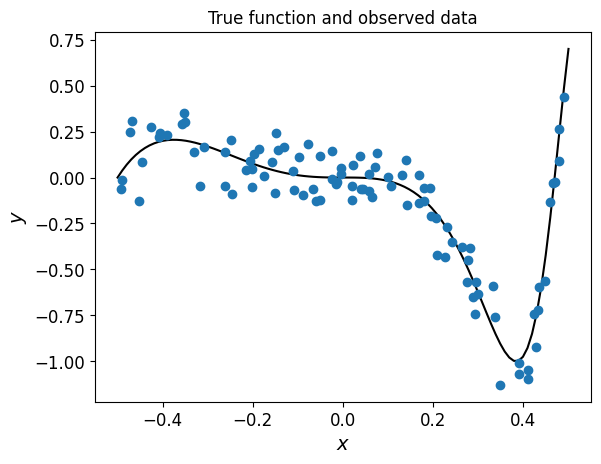

In [2]:
import math

def testfunc(x):
    # You might want to try this alternative function to experiment.
    # 你可能想尝试这个备选函数进行实验。
    #y = np.sin((4*math.pi*x**2))
    y = -np.sin((10*math.pi*(x+0.5)*np.sin((x)**3)))#构造了一个复杂的非线性函数
    return y

#创建一个在-0.5到0.5之间均匀分布的100个点的网格，并调整形状以符合后续操作
xgrid = torch.t(torch.linspace(-0.5,0.5,100)).unsqueeze(1)#生成一个线性间隔的 xgrid，用于画出未被噪声影响的真实函数。
#首先生成一个一维张量，包含了从-0.5到0.5的100个等间隔的点
#然后对其进行转置
#随后利用.unsqueeze(1)操作增加一个维度，转换为而为张量，新加的维度位置为1（也就是第二个位置），相当于将100个点的一维数组转换为一个100x1的二维数组（行向量）

# 使用定义好的函数生成这些点的真实值（干净的数据，用于可视化，但不用于学习）
ytrue = testfunc(xgrid) # clean data from underlying function (not available for learning)
#ytrue就是xgrid对应点上的函数值

# now create some training data
# 现在创建一些训练数据
N = 100         # number of noisy training observations made #噪声训练观察值的数量
noiseSigma = 0.1   # standard deviation of noise #噪声的标准差
noiseMean = 0.0    # mean of noise #噪声的均值

# 生成N个在-0.5到0.5之间均匀分布的随机样本点
#创建1个与给定形状（Nx1）相同的新张量，其中每个元素都是[0,1)区间内的均匀分布中的数
#然后从生成的随机数张量中对每个元素-0.5来将随机数转换到[-0.5,0.5)区间
x = torch.rand_like(torch.ones(N,1))-0.5
#生成N个高斯噪声样本（同样是一个Nx1的随机数张量，并对元素乘以标准差并加上均值
obserr = torch.randn(N,1)*noiseSigma + noiseMean
#生成带有噪声的训练数据点y值
y = testfunc(x)+obserr

#创建测试数据集，用于验证模型（基本相同的代码，只不过更换了随机生成的x值，作为测试样本
#xtest,ytest与训练数据及类似，但用于模型验证而非训练
xtest  = torch.rand_like(torch.ones(N,1))-0.5
obserr = torch.randn(N,1)*noiseSigma + noiseMean
ytest  = testfunc(xtest)+obserr

#绘制真实函数和观测数据（绘制真实函数的图像和观测到的带噪声的数据点
fig = plt.figure()
plt.plot(xgrid, ytrue,'-k')#绘制真实函数的图像
plt.plot(x,y,'o')#绘制观测到的数据点
plt.title('True function and observed data')
plt.xlabel('$x$')
plt.ylabel('$y$')

# Train a simple "fully connected" multi-layer perceptron (MLP) network to model this data.

# 训练一个简单的“全连接”多层感知器（MLP）网络来对这些数据进行建模。

Make sure you understand how this code is working - ask questions !

How many layers does this network have? How many neurons in the layers? Can you extend the number of layers? How many connections between the different layers? (See the output from the code ...)

这个网络有多少层？每层有多少个神经元？你能增加层数吗？不同层之间有多少连接？（参见代码的输出...）

Do you get an improvement of the loss over time? (Epochs of training)

随着时间的推移（训练的轮次），损失有改善吗？

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Nhidden = 10    # Try increasing the number of units # 尝试增加单元的数量
lr = 0.01 #学习率
epochs = 30000 #训练的轮次

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()#可以调用Net类的父类nn.Module的构造函数，即可以使用nn.Module中定义的各种方法和属性

        # An affine operation: y = Wx + b #一个仿射操作y=Wx+b
        #对输入数据进行相应的线性变换
        #第一个参数表示输入特征的数量，在此设定为1表示每个输入样本只有1个特征
        #第二个参数Nhidden达标全脸阶层的输入特征的数量，即隐藏层中神经元的数量（这里设定为10）
        #第一层是一个全脸阶层，从输入特征映射到隐藏层
        self.fc1 = nn.Linear(1, Nhidden)  # See https://pytorch.org/docs/stable/nn.html#linear for documentation

        # See later in the notebook why you might want to do this ! # 在笔记本后面你会了解为什么你可能想要这么做！
        # self.fc1a = nn.Linear(Nhidden, Nhidden)

        # 你能找出权重是如何初始化的吗？
        # 在源代码中，权重通过init.kaiming_uniform_(self.weight, a=math.sqrt(5))这条命令来初始化
        #采用了Kaiming 均匀初始化方法，kaiming_uniform_ 是对权重进行初始化的函数，它根据权重矩阵的尺寸自动计算均匀分布的范围。
        #参数 a 是Kaiming初始化中的负半区间的平方根，这里设定为sqrt(5)，可以与使用范围(-1/(sqrt(in_features)))到(1/(sqrt(in_features)))的均匀分布进行初始化的效果相同

        #这是第二层，也是个全脸阶层，将隐藏层的输出映射到单个输出值
        self.fc2 = nn.Linear(Nhidden, 1)  # Can you find out how the weights are initialised? Look in the PyTorch source code https://github.com/pytorch/pytorch/blob/master/torch/nn/modules/linear.py

    #前馈传播函数
    def forward(self, x):
        # 尝试将这个改为 tanh() 或 sigmoid()
        #这里使用了relu()做激活函数，还可以使用tanh()或者sigmoid()作为激活函数
        x = F.relu(self.fc1(x))  # try changing this to tanh() or sigmoid()

        # See later in the notebook why you might want to do this !
        # 在笔记本后面你会了解为什么你可能想要这么做！
        # x = F.tanh(self.fc1a(x))
        x = self.fc2(x)
        #想要一个全面的输出，所以不再跟一个激活函数
        return x

net = Net()
print(net)

criterion = nn.MSELoss() #计算均方误差损失，均方误差作为损失函数
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)#利用SGD随机下降梯度作为优化器，通过调整学习率和动量来优化网络参数
#扫描并调用了网络中的所有可训练的参数作为迭代器，将它们作为一个生成器返回



for epoch in range(epochs):  # loop over the dataset multiple times #。对数据集进行多轮循环
    running_loss = 0.0

    # zero the parameter gradients
    # 清零参数梯度
    optimizer.zero_grad()

    # forward + backward + optimize
    # 向前传播+反向传播+优化
    outputs = net(x)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

    # print statistics # 打印统计信息
    running_loss += loss.item() #将当前回合的损失值（一个单一的标量张量）转换为Python浮点数，并驾到running_loss上
    if epoch % 2000 == 1999:    # print every 2000 mini-batches #  # 每2000次迭代打印一次
        print('[%d, %5d] loss: %.3f' %
              (epoch + 1, 0 + 1, running_loss))
        running_loss = 0.0

print('Finished Training')



Net(
  (fc1): Linear(in_features=1, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=1, bias=True)
)
[2000,     1] loss: 0.059
[4000,     1] loss: 0.055
[6000,     1] loss: 0.051
[8000,     1] loss: 0.042
[10000,     1] loss: 0.031
[12000,     1] loss: 0.021
[14000,     1] loss: 0.016
[16000,     1] loss: 0.014
[18000,     1] loss: 0.013
[20000,     1] loss: 0.012
[22000,     1] loss: 0.012
[24000,     1] loss: 0.012
[26000,     1] loss: 0.012
[28000,     1] loss: 0.012
[30000,     1] loss: 0.012
Finished Training


# Use the model to do predictions!

# 使用模型来做预测

Does it work as well as you would hope?

它的工作效果如你所愿吗？

How about if you add in the extra layer into the network? (Need to go back and update the model.) How has it changed the "architecture" of the network in terms of layers, number of neurons in those layers and number of connections between the layers? How has this changed the loss over epochs ? How has it changed the fit given below ?

如果你在网络中增加额外的层会怎样？（需要返回去更新模型。）这如何改变网络的“架构”，包括层的数量、这些层中的神经元数量，以及层与层之间的连接数量？这如何改变了随着训练轮次变化的损失？这如何改变了下面给出的拟合效果？

Text(0.5, 1.0, 'Regression comparison')

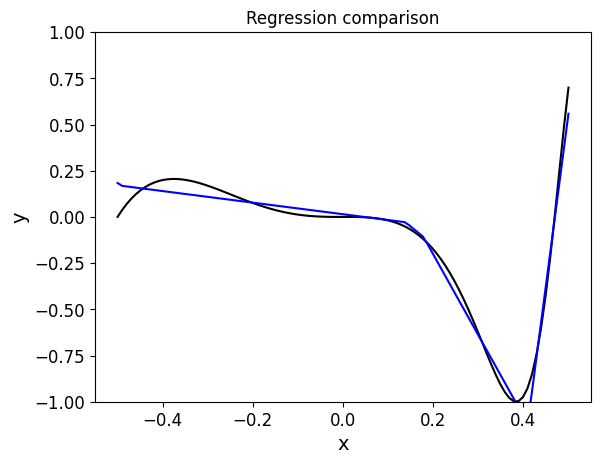

In [4]:
pred_y = net(x) #通过神经网络net对训练数据x进行预测，得到预测值pred_y
pred_ygrid = net(xgrid) #对前面的网格化输入数据进行预测，得到在网格点上的预测值pred_ygrid

plt.figure()
plt.plot(xgrid, ytrue,'k-') #将真实函数值绘制出来
plt.plot(xgrid, pred_ygrid.detach().numpy(),'b-')#将网格上的预测值张量用.detach()方法穿进一个新张量，使新张量不会在梯度计算中，因为不打算对该数据进行反向传播
#然后再将这个张量转换成Numpy数组，并绘制出来

plt.xlabel('x')
plt.ylabel('y')
plt.ylim([-1, 1])
plt.title('Regression comparison')

You can view the parameter values of the layers as a list of numpy arrays using the .weight command in pyTorch. Each layer can be accessed independently.

Do the number of weights and bias terms printed make sense here given the structure of this network ?




In [5]:
print('First hidden layer weights', torch.t(net.fc1.weight)) # first hidden layer weights (transposed for ease of inspection)
print('First hidden layer biases', net.fc1.bias) # first hidden layer biases
print('Second layer weights',net.fc2.weight) # second layer
print('Second layer bias', net.fc2.bias) # second layer

First hidden layer weights tensor([[ 1.2906, -0.3308, -0.3480, -1.4470, -1.6306,  0.2130, -3.8070, -0.4485,
          0.8523, -4.6190]], grad_fn=<TBackward0>)
First hidden layer biases Parameter containing:
tensor([ 0.6367, -0.4217, -0.6451,  0.2006,  0.2913,  0.2007,  2.1377, -0.2765,
         0.8178,  1.8923], requires_grad=True)
Second layer weights Parameter containing:
tensor([[ 1.4469, -0.1320,  0.2445, -1.1691, -1.4530,  0.1406, -4.2586,  0.2277,
          0.5519,  4.9694]], requires_grad=True)
Second layer bias Parameter containing:
tensor([-1.0289], requires_grad=True)


# Do further experimentation on this regression problem to improve it ...

Experiment (possibly changing one thing at a time for comparison) with:

1. The amount of training data (try 100, 200, 1000 points), and noise levels on the data (try 0.01 and 0.1 for noiseSigma).
2. The number of units (neurons) in the model (essentially the "width" of the network).
3. The choice of activation function.
4. Add an extra layer of hidden units to the network and compare performance between two layers of N units and one layer of 2N units (essentially the "depth" of the network).

Compare these by plotting a visualisation of the network output at `xgrid` inputs, and compare it with the `ytrue` results.





---



# Task 2 - Classification

Now we will try out some experiments with simple two-dimensional classification tasks. Again read through the code to make sure you feel you understand how it is working. For instance, how does meshgrid() work? Look it up in the PyTorch documentation if you are not sure what it is doing. See if you can work out the shape (or size) of the tensors involved (can always print out value.shape to checkthis !) For instance, what shape does `x` have in this code ?


**Dataset 1**


In [ ]:
N = 200

xgrid = torch.arange(0,1.0,0.01)

X,Y = torch.meshgrid(xgrid, xgrid)
testgrid = torch.zeros((np.shape(xgrid)[0]**2,2))
testgrid[:,0] = X.flatten()
testgrid[:,1] = Y.flatten()


# What distribution is produced by torch.randn ?
# Try experimenting with different types of input distribution
# x = np.random.uniform(low = 0.0, high = 1.0, size= (N,2))

x = 0.2*torch.randn(N,2)+torch.tensor([0.5, 0.5])

y = ((torch.linalg.vector_norm(x-0.5, dim=1) < 0.2)*1.0).type(torch.float)  # make the class be a circle in the centre of the scene.

# cut out a border around the classes to make the task a bit more realistic
ind_incl = (torch.linalg.vector_norm(x-0.5, dim=1) > 0.25) | (torch.linalg.vector_norm(x-0.5, dim=1) < 0.20)
x = x[ind_incl,:]
y = y[ind_incl]
N = y.shape[0]
y = y.reshape(N,1)
print(N)

Ntest = 1000
xtest = 0.2*torch.randn(Ntest,2)+torch.tensor([0.5, 0.5])
ytest = ((torch.linalg.vector_norm(xtest-0.5, dim=1) < 0.2)*1.0).type(torch.float)

# cut out a border around the classes to make the task a bit more realistic
ind_incl = (torch.norm(xtest-0.5, dim=1) > 0.25) | (torch.norm(xtest-0.5, dim=1) < 0.20)
xtest = xtest[ind_incl,:]
ytest = ytest[ind_incl]

Ntest = ytest.shape[0]
ytest = ytest.reshape(Ntest,1)

plt.figure()
plt.scatter(x[:,0].numpy(),x[:,1].numpy(), alpha=0.2, s=90, cmap='viridis', c=y.view(-1))
plt.title('Dataset 1')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

---

# Define a suitable MLP or "fully-connected" model

This type of simple network can alternatively be created using the nn.Sequential container. See this [Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) class page in the PyTorch documentation for an example of this.


What is the size of the input to this model? What is the size of output? Why do we have a sigmoid activation function on the output? (See the printed output.)



In [ ]:
Nhidden = 10
lamb=0.0000    # L2 weight decay term
lr = 0.01
epochs = 20000


class Net2d(nn.Module):
    def __init__(self):
        super(Net2d, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(2, Nhidden)
        self.fc2 = nn.Linear(Nhidden, Nhidden)
        self.fc3 = nn.Linear(Nhidden, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

net2d = Net2d()
print(net2d)



# Training the network

What type of loss are we using here? Why are we not using MSELoss ?

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.SGD(net2d.parameters(), lr=lr, momentum=0.9, weight_decay=lamb) # Note that this is adding L2 regularisation with factor lamb to every parameter

for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net2d(x)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if epoch % 2000 == 1999:    # print every 2000 mini-batches
        print('[%d, %5d] loss: %.3f' %
              (epoch + 1, 0 + 1, running_loss))
        running_loss = 0.0


# Using the network to do prediction

In [ ]:
pred_test = net2d(xtest)
plt.figure()
plt.scatter(xtest[:,0],xtest[:,1], alpha=0.2, s=90, cmap='viridis', c=pred_test[:,0].detach().numpy())
plt.title('Dataset 1')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

pred_testgrid = net2d(testgrid)
plt.figure()
plt.scatter(testgrid[:,0],testgrid[:,1], alpha=0.2, s=90, cmap='viridis', c=pred_testgrid[:,0].detach().numpy())
plt.title('Dataset 1 fine response')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

print('Final training set loss ', criterion(outputs, y).item())
test_loss = criterion(pred_test, ytest)
print('Test loss ', test_loss.item())
classification = torch.round(pred_test)
percentage = 100*sum(ytest.type(torch.int) == classification.type(torch.int))/Ntest
print('Percentage correct ', percentage.item())

# Experiment with the following ...

Try repeating these experiments with the following variations:
- Try with 200, 500, 2000 training points. How does that change the response of the function?
- Try changing the number of hidden units. What changes?
    - Do you see as many 'edges' on the decision boundary when using ReLUs as units? Why do you think this is?
    - Try with 1,2,3 hidden layers.
- Try with Sigmoids in the hidden layer rather than ReLUs.
    - How does that change the shape of the decision boundary? Why do you think this is?
    - How does it change the speed of error reduction?

- Try changing the loss function from Binary Cross-Entropy (`BCEloss`) to `MSEloss`. How does that affect performance? How does it affect perfomance in `mse`?
- During the above you may find that some configurations take a lot longer to reduce the error than others.


The correct choice of loss function is linked to the output type, as shown in the table below:

![output/cost function table](https://docs.google.com/uc?export=download&id=1Z2C-NJh35shzvtMlvEtDpyQgGM10bvew)







---



# Task 3 - Classification


Let's do a classification based on the boundary that we used for regression !

---

**Dataset 2**

In [ ]:
N = 100   # Try 100, 500, 1000

xgrid1 = torch.arange(0,1.0,0.01)

#try experimenting with different types of input distribution
data_dist = 1 # 1 - uniform 0.5-0.5, 2 - normally distributed

if data_dist == 1:
   x = torch.rand(N,2)
else:
   x = 0.15*torch.randn(N,2)+torch.tensor([0.5, 0.5])
ind_pos = (0.5+0.4*testfunc(x[:,0]-0.5)<x[:,1])
y = (ind_pos*1.0).type(torch.float)  # lets create a classification line based on old regression function
N = y.shape[0]
y = y.reshape(N,1)
x[ind_pos,1] = x[ind_pos,1]+0.05 # create a gap between classes.


if data_dist == 1:
  xtest = torch.rand(N,2)
else:
  xtest = 0.15*torch.randn(N,2)+torch.tensor([0.5, 0.5])
ind_post = (0.5+0.4*testfunc(xtest[:,0]-0.5)<xtest[:,1])
ytest = (ind_post*1.0).type(torch.float)  # let's create a classification line based on old regression function
Ntest = ytest.shape[0]
ytest = ytest.reshape(Ntest,1)
xtest[ind_post,1] = xtest[ind_post,1]+0.05 # create a gap between classes.


plt.figure()
plt.scatter(x[:,0],x[:,1], alpha=0.2, s=90, cmap='viridis', c=y.view(-1))
plt.plot(xgrid1, 0.5+0.4*ytrue,'--k')  # show the 'true' classification line for this problem
plt.title('Dataset 2')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')



# Define the model

This time we will use the Sequential container that was mentioned above to define this model.

In [ ]:
Nhidden = 10 # experiment with this
lamb=0.00
lr = 0.01
epochs = 50000


net2d = nn.Sequential(nn.Linear(2,Nhidden),
                      nn.ReLU(),
                      nn.Linear(Nhidden, Nhidden),
                      nn.ReLU(),
                      nn.Linear(Nhidden, 1),
                      nn.Sigmoid())
# reuse net2d variable.


# Train the model

Does the loss change during training? What is this telling you?

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.SGD(net2d.parameters(), lr=lr, momentum=0.9, weight_decay=lamb) # Note that this is adding L2 regularisation with factor lamb to every parameter

for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net2d(x)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if epoch % 2000 == 1999:    # print every 2000 mini-batches
        print('[%d, %5d] loss: %.3f' %
              (epoch + 1, 0 + 1, running_loss))
        running_loss = 0.0

# Do prediction on the test set using the model

In [ ]:
pred_test = net2d(xtest)
plt.figure()
plt.scatter(xtest[:,0],xtest[:,1], alpha=0.2, s=90, cmap='viridis', c=pred_test[:,0].detach().numpy())
plt.plot(xgrid1, 0.5+0.4*ytrue,'--k')  # show the 'true' classification line for dataset2 problem
plt.title('Dataset 2')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

pred_testgrid = net2d(testgrid)
plt.figure()
plt.scatter(testgrid[:,0],testgrid[:,1], alpha=0.2, s=90, cmap='viridis', c=pred_testgrid[:,0].detach().numpy())
plt.plot(xgrid1, 0.5+0.4*ytrue,'--k')  # show the 'true' classification line for this problem
plt.title('Dataset 2 fine response')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

print('Final training set loss ', criterion(outputs, y).item())
test_loss = criterion(pred_test, ytest)
print('Test loss ', test_loss.item())
classification = torch.round(pred_test)
percentage = 100.0*torch.sum(ytest.type(torch.int) == classification.type(torch.int))/Ntest
print('Percentage correct ', percentage.item())

# Try experimenting with the following aspects of this network:

Try changing the distribution of the training data (e.g. make it normally distributed) but keeping the same classification boundary. How does that change the resulting classification boundary?

Try with N= 100, 500, 1000 training examples with linearly distribute and normally distributed data. What is this telling you?

Try different sizes of network to see what differences result.

What happens with small training sets and large networks?